In [102]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [103]:
GITHUB_MOH = (
    "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/"
)

FILES = [
    "cases_malaysia",
    "deaths_malaysia",
    "hospital",
    "icu",
    "cases_state",
    "deaths_state",
]

REGION = "Malaysia"


In [104]:
def fetch_mys_data():

    a_list = []
    for file in FILES:
        data_type = file.split('_')[0]
        df = pd.read_csv(GITHUB_MOH + file + ".csv")
        df['type']  = data_type

        a_list.append(df)
    df = pd.concat(a_list)

    return df

In [105]:
df = fetch_mys_data()

In [106]:
df.loc[df['state'].isna(), 'state'] = 'Malaysia'

In [107]:
df.columns


Index(['date', 'cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax',
       'cases_boost', 'cases_child', 'cases_adolescent', 'cases_adult',
       'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
       'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
       'cases_60_69', 'cases_70_79', 'cases_80', 'cluster_import',
       'cluster_religious', 'cluster_community', 'cluster_highRisk',
       'cluster_education', 'cluster_detentionCentre', 'cluster_workplace',
       'type', 'deaths_new', 'deaths_bid', 'deaths_new_dod', 'deaths_bid_dod',
       'deaths_unvax', 'deaths_pvax', 'deaths_fvax', 'deaths_boost',
       'deaths_tat', 'state', 'beds', 'beds_covid', 'beds_noncrit',
       'admitted_pui', 'admitted_covid', 'admitted_total', 'discharged_pui',
       'discharged_covid', 'discharged_total', 'hosp_covid', 'hosp_pui',
       'hosp_noncovid', 'beds_icu', 'beds_icu_rep', 'beds_icu_total',
 

In [108]:
FILTER = (df['state'] == REGION) & (df['type'] == 'deaths')

<AxesSubplot:xlabel='date'>

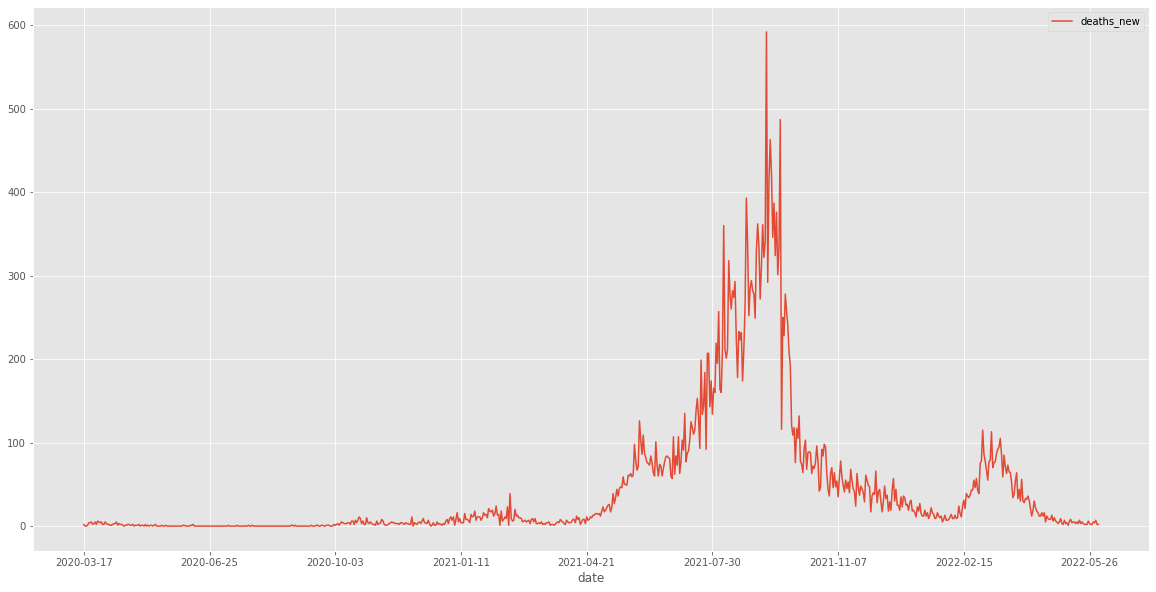

In [109]:
df[FILTER].plot(x='date', y='deaths_new', figsize=(20, 10))

In [110]:
POPULATION = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv'

df_pop = pd.read_csv(POPULATION)

In [114]:
df_pop

,state,idxs,pop,pop_18,pop_60,pop_12,pop_5
0,Malaysia,0,32657100,23528200,3649000,3111400,3550500
1,Johor,1,3794200,2733400,445600,353900,409800
2,Kedah,2,2193600,1554800,282300,209700,254100
3,Kelantan,3,1928900,1258700,202100,211200,271700
4,Melaka,4,937800,683700,123200,85600,98200
5,Negeri Sembilan,5,1128900,819200,150300,105900,117200
6,Pahang,6,1684700,1188000,198100,172000,192600
7,Pulau Pinang,7,1774200,1374300,247600,139400,155600
8,Perak,8,2509000,1878100,410000,228000,239700
9,Perlis,9,255500,182100,36300,23000,29100


In [120]:
initial_population = df_pop[df_pop['state'] == REGION]['pop'][0]

# Basic model introduction

This page introduces the processes for building and running a simple compartmental disease model with Summer.
In the following example, we will create an SIR compartmental model for a general, unspecified emerging infectious disease spreading through a fully susceptible population. In this model there will be:

- three compartments: susceptible (S), infected (I) and recovered (R)
- a starting population of the REGION, with 10 of them infected (and infectious)
- an evaluation timespan from day zero to END_DATE in 0.1 day steps
- inter-compartmental flows for infection, deaths and recovery

First, let's look at a complete example of this model in action, and then examine the details of each step. This is the complete example model that we will be working with:

In [121]:
import numpy as np
from summer import CompartmentalModel

END_DATE = 300

In [132]:
# Define the model
model = CompartmentalModel(
    times=(40, END_DATE),
    compartments=["S", "E", "I", "R"],
    infectious_compartments=["I"],
    timestep=0.1,
)

In [133]:

model.set_initial_population(distribution={"S": initial_population, "E": 0, "I": 10})
model.add_infection_frequency_flow(name="exposure", contact_rate=0.65, source="S", dest="E")
model.add_transition_flow(name="infection", fractional_rate=1/3, source="E", dest="I")
model.add_transition_flow(name="recovery", fractional_rate=0.2, source="I", dest="R")
#model.add_death_flow(name="infection_death", death_rate=0.05, source="I")

# Run the model
model.run()


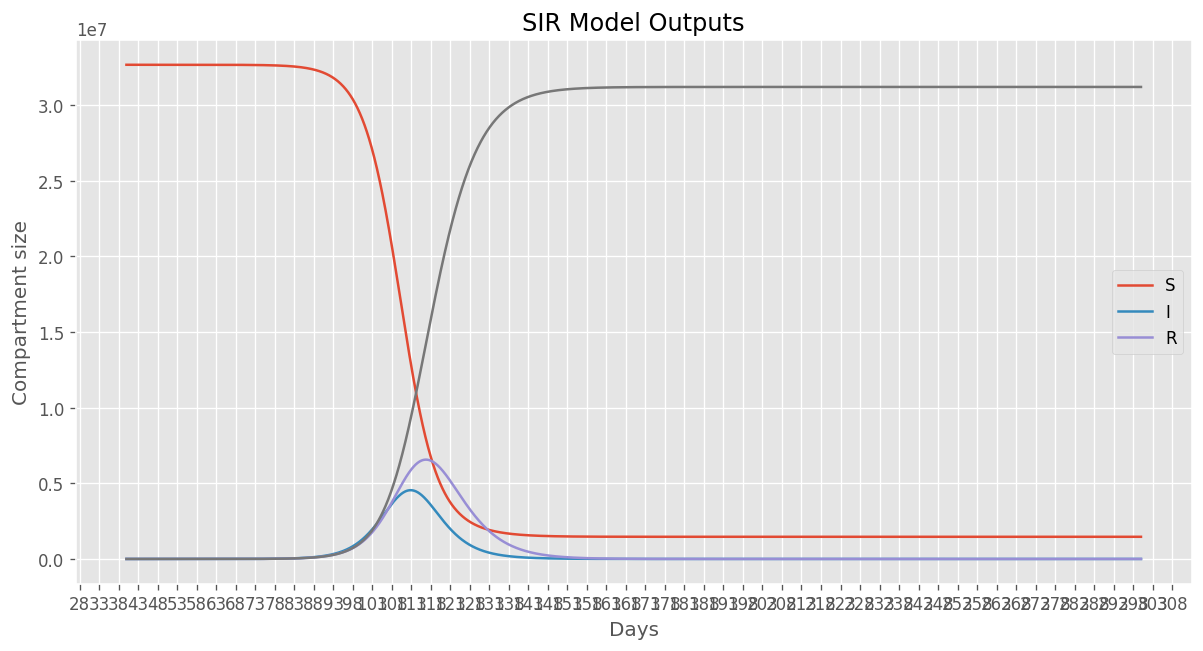

In [141]:

# Visualize the results.
subplot = {"title": "SIR Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot)
for compartment_idx in range(model.outputs.shape[1]):
    ax.plot(model.times, model.outputs.T[compartment_idx])

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
ax.legend(["S", "I", "R"])
plt.show();


Now let's inspect each step of the example in more details. To start, here's how to create a new model: let's import the summer library and create a new [CompartmentalModel](/api/model.html) object. You can see that our model has an attribute called `compartments`, which contains a description of each modelled compartment.

In [7]:
from summer import CompartmentalModel

model = CompartmentalModel(
    times=[0, 20],
    compartments=["S", "I", "R"],
    infectious_compartments=["I"],
    timestep=0.1,
)

# View a description of the model compartments
model.compartments

[S, I, R]

## Adding a population 

Initially the model compartments are all empty. Let's add:

- 990 people to the susceptible (S) compartment, plus
- 10 in the infectious (I) compartment.

In [8]:
# Add people to the model
model.set_initial_population(distribution={"S": 990, "I": 10})

# View the initial population
model.initial_population

array([990.,  10.,   0.])

## Adding inter-compartmental flows 

Now, let's add some flows for people to transition between the compartments. These flows will define the dynamics of our infection. We will add:

- an infection flow from S to I (using frequency-dependent transmission)
- a recovery flow from I to R
- an infection death flow, that depletes people from the I compartment

In [9]:
# Susceptible people can get infected.
model.add_infection_frequency_flow(name="infection", contact_rate=1, source="S", dest="I")

# Infectious people take 3 days, on average, to recover.
# If the model was run at this stage of construction, 
# then the basic reproduction number (R0) of this infection would be 3.
model.add_transition_flow(name="recovery", fractional_rate=1/3, source="I", dest="R")

# Add an infection-specific death flow to the I compartment.
# This now slightly reduces the actual sojourn time in the I compartment
# from the original request of 3 days, and so slightly reduces R0 as well.
model.add_death_flow(name="infection_death", death_rate=0.05, source="I")

# Inspect the new flows, which we just added to the model.
model._flows

[<InfectionFrequencyFlow 'infection' from S to I>,
 <TransitionFlow 'recovery' from I to R>,
 <DeathFlow 'infection_death' from I>]

## Running the model

Now we can calculate the outputs for the model over the requested time period. 
The model calculates the compartment sizes by solving a system of differential equations (defined by the flows we just added) over the requested time period.

In [10]:
model.run()

## Print the model outputs

The model's results are available in a NumPy array named `model.outputs`. 
This array is available after the model has been run. Let's have a look at what's inside:

In [11]:
# Force NumPy to format the output array nicely. 
import numpy as np
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

# View the first 25 timesteps of the output array.
model.outputs[:25]

array([[990.00, 10.00, 0.00],
       [988.98, 10.62, 0.34],
       [987.90, 11.29, 0.71],
       [986.75, 11.99, 1.10],
       [985.53, 12.74, 1.51],
       [984.24, 13.53, 1.95],
       [982.86, 14.36, 2.41],
       [981.41, 15.25, 2.90],
       [979.87, 16.19, 3.43],
       [978.23, 17.18, 3.98],
       [976.50, 18.24, 4.57],
       [974.67, 19.35, 5.20],
       [972.73, 20.53, 5.87],
       [970.67, 21.78, 6.57],
       [968.49, 23.09, 7.32],
       [966.19, 24.48, 8.11],
       [963.75, 25.95, 8.95],
       [961.18, 27.51, 9.84],
       [958.45, 29.14, 10.79],
       [955.58, 30.87, 11.79],
       [952.54, 32.69, 12.84],
       [949.34, 34.60, 13.97],
       [945.96, 36.62, 15.15],
       [942.39, 38.74, 16.41],
       [938.63, 40.97, 17.74]])

## Plot the outputs

You can get a better idea of what is going on inside the model by visualizing how the compartment sizes change over time.

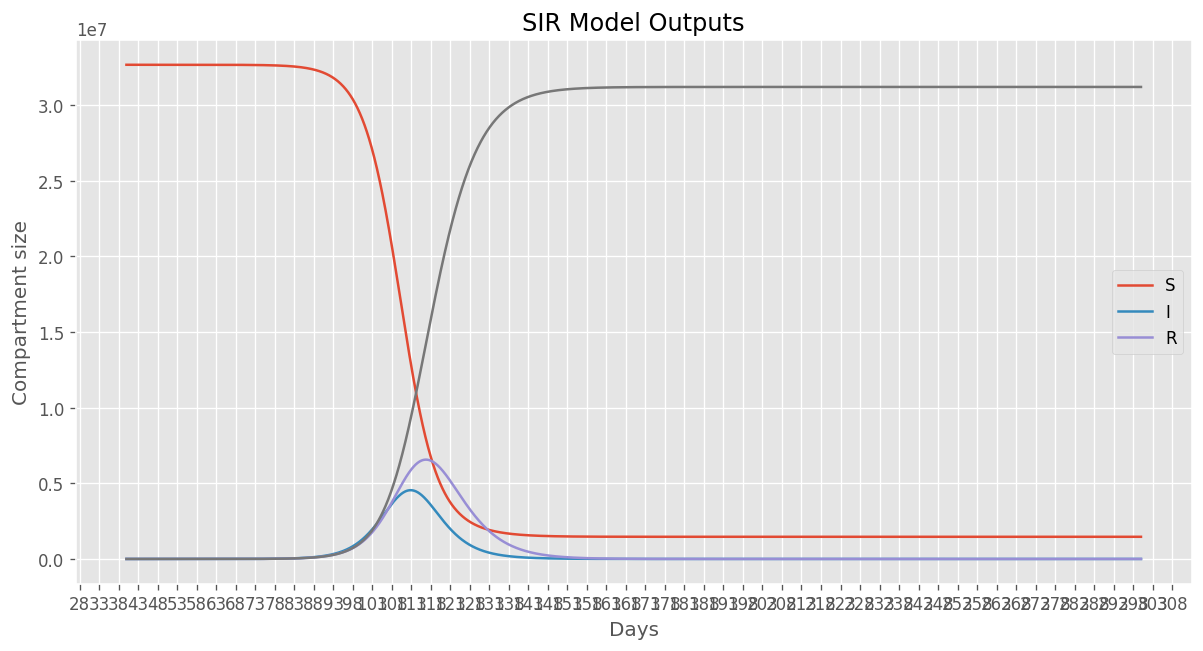

In [140]:
import numpy as np
import matplotlib.pyplot as plt

subplot = {"title": "SIR Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot)
for compartment_idx in range(model.outputs.shape[1]):
    ax.plot(model.times, model.outputs.T[compartment_idx])

start, end = ax.get_xlim()

ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
ax.legend(["S", "I", "R"])
plt.show();

## Summary

That's it for now, now you know how to:

- Create a model
- Add a population
- Add flows
- Run the model
- Access and visualize the outputs

A detailed API reference for the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)

## Bonus: how the model works inside

This section presents a code snippet that shows an approximation of what is happening inside the model we just built and ran.

In the example code below we use the [Euler method](https://en.wikipedia.org/wiki/Euler_method) to solve an ordinary differential equation (ODE) which is defined by the model's flows. We don't actually use Euler in Summer though, you can read more about the actual ODE solvers available to evaluate models [here](http://summerepi.com/examples/4-ode-solvers.html).

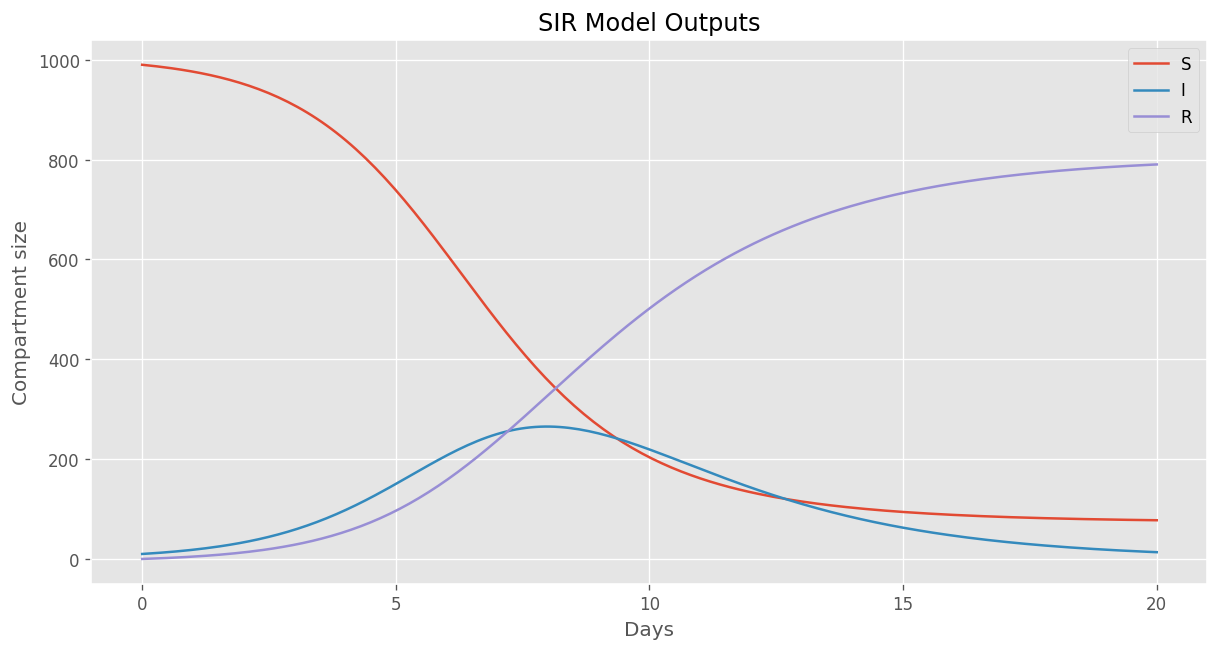

In [137]:
import numpy as np
import matplotlib.pyplot as plt

TIMESTEP = 0.1
START_TIME = 0
END_TIME = 20

# Get times
time_period = END_TIME - START_TIME + 1
num_steps = time_period / TIMESTEP
times = np.linspace(START_TIME, END_TIME, num=int(num_steps))

# Define initial conditions
initial_conditions = np.array([990.0, 10.0, 0.0])  # S, I, R

# Define outputs
outputs = np.zeros((int(num_steps), 3))
outputs[0] = initial_conditions

# Model parameters
contact_rate = 1.0
sojourn_time = 3.0
death_rate = 0.05

# Calculate outputs for each timestep
for t_idx, t in enumerate(times):
    if t_idx == 0:
        continue

    flow_rates = np.zeros(3)
    compartment_sizes = outputs[t_idx - 1 ]

    # Susceptible people can get infected (frequency-dependent).
    num_sus = compartment_sizes[0]
    num_inf = compartment_sizes[1]
    num_pop = compartment_sizes.sum()
    force_of_infection = contact_rate * num_inf / num_pop
    infection_flow_rate = force_of_infection * num_sus
    flow_rates[0] -= infection_flow_rate
    flow_rates[1] += infection_flow_rate

    # Infectious take some time to recover.
    num_inf = compartment_sizes[1]
    recovery_flow_rate = num_inf / sojourn_time
    flow_rates[1] -= recovery_flow_rate
    flow_rates[2] += recovery_flow_rate
    
    # Add an infection-specific death flow to the I compartment.
    num_inf = compartment_sizes[1]
    recovery_flow_rate = num_inf * death_rate
    flow_rates[1] -= recovery_flow_rate
    
    # Calculate compartment sizes at next timestep given flowrates.
    outputs[t_idx] = compartment_sizes + flow_rates * TIMESTEP  
    
# Plot the results as a function of time for S, I, R respectively.
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)

# Add each compartment to the plot.
for i in range(outputs.shape[1]):
    ax.plot(times, outputs.T[i])

ax.set_title("SIR Model Outputs")
ax.set_xlabel("Days")
ax.set_ylabel("Compartment size")
ax.legend(["S", "I", "R"])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
plt.show();